In [11]:
from pathlib import Path
import numpy as np, pandas as pd
from itertools import product

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
# --- CELDA 0: RUTAS ROBUSTAS ---

# Busca la raíz del proyecto (para poder ejecutar desde /notebooks)
def find_root(start=None, max_up=6):
    p = Path.cwd() if start is None else Path(start)
    for _ in range(max_up):
        if (p / "data" / "raw").exists():
            return p
        p = p.parent
    raise FileNotFoundError("No se encontró la carpeta 'data/raw'.")

ROOT      = find_root()
DATA_RAW  = ROOT / "data" / "raw"
DATA_PROC = ROOT / "data" / "processed"
REPORTS   = ROOT / "reports" / "tables"
for d in (DATA_PROC, REPORTS): d.mkdir(parents=True, exist_ok=True)

print("Rutas configuradas correctamente ✅")

print("ROOT     →", ROOT)
print("DATA_RAW →", DATA_RAW)
print("DATA_PROC→", DATA_PROC)



Rutas configuradas correctamente ✅
ROOT     → c:\Users\Gerson\Downloads\PISA-ML
DATA_RAW → c:\Users\Gerson\Downloads\PISA-ML\data\raw
DATA_PROC→ c:\Users\Gerson\Downloads\PISA-ML\data\processed


In [12]:
# --- CELDA 1: CARGA (X, y) DESDE data/processed ---

import pandas as pd

X_PATH = DATA_PROC / "peru_X_full__part1.xlsx"
Y_PATH = DATA_PROC / "y_3niveles.xlsx"

assert X_PATH.exists(), f"No encontré {X_PATH}"
assert Y_PATH.exists(), f"No encontré {Y_PATH}"

# 1) Cargar X
X = pd.read_excel(X_PATH, engine="openpyxl")

# 2) Cargar y desde MATH_LEVEL_3CAT (low/mid/high)
ydf  = pd.read_excel(Y_PATH, engine="openpyxl")
cols = {c.upper(): c for c in ydf.columns}
assert "MATH_LEVEL_3CAT" in cols, f"No veo 'MATH_LEVEL_3CAT' en columnas: {list(ydf.columns)}"
coly = cols["MATH_LEVEL_3CAT"]

y_raw = ydf[coly].astype(str).str.strip().str.lower()
y_map = {"low": 0, "med": 1, "high": 2}
y_all = y_raw.map(y_map)

# 3) Reportar etiquetas inválidas (si las hubiera) y filtrar
bad = y_all.isna()
if bad.any():
    rep = pd.DataFrame({"raw": ydf[coly], "normalizado": y_raw, "mapped": y_all})[bad]
    rep.to_excel(REPORTS / "y_labels_invalidas.xlsx", index=False)
    print(f"Aviso: {bad.sum()} fila(s) con etiquetas fuera de {{low, med, high}}. "
          f"Detalle en reports/tables/y_labels_invalidas.xlsx")

# 4) Alinear X e y (misma longitud y eliminar inválidas)
nmin = min(len(X), len(y_all))
mask_keep = (~bad).iloc[:nmin]
X = X.iloc[:nmin].loc[mask_keep].reset_index(drop=True)
y = y_all.iloc[:nmin].loc[mask_keep].reset_index(drop=True)

print("CARGA OK ✅")
print("X:", X.shape, "| y:", y.shape)
print("Distribución y (0=low,1=med,2=high):", y.value_counts().sort_index().to_dict())


CARGA OK ✅
X: (6968, 68) | y: (6968,)
Distribución y (0=low,1=med,2=high): {0: 4590, 1: 2352, 2: 26}


In [13]:
# --- CELDA COMPLETA: Binario Low (0) vs Medium (1) con impresión inmediata ---

import pandas as pd

def make_low_vs_med(
    X, y,
    sample_pos=None,          # int opcional: cuántos Medium tomar
    balance=False,            # si True, iguala #Medium a #Low
    random_state=42,
    save=False,               # si True, guarda a /data/processed y reporte a /reports/tables
    name="low_vs_med"         # sufijo para archivos
):
    """
    Construye tarea binaria: y_bin = 0 si Low (0); 1 si Medium(1).
    - Incluye TODOS los Low.
    - Para Medium: toma todos, o 'sample_pos' si se especifica, o balancea si balance=True.
    - EXCLUYE por completo los High (2).
    - Imprime un reporte con desglose.
    - Retorna (Xb, yb).
    """
    # Asegurar Series
    y = pd.Series(y)

    # Máscaras originales
    m_low = (y == 0)
    m_med = (y == 1)

    idx_low = y[m_low].index
    idx_med_all = y[m_med].index   # solo Medium como positivos

    # Decidir tamaño de positivos (Medium)
    if balance:
        sample_pos = len(idx_low)
    if isinstance(sample_pos, int):
        if sample_pos > len(idx_med_all):
            raise ValueError(f"Pediste {sample_pos} Medium, pero solo hay {len(idx_med_all)}.")
        idx_med = (
            pd.Series(idx_med_all)
            .sample(n=sample_pos, random_state=random_state, replace=False)
            .values
        )
    else:
        idx_med = idx_med_all

    # Unir y barajar (solo Low + Medium)
    idx_take = pd.Index(idx_low).append(pd.Index(idx_med))
    idx_take = pd.Index(
        pd.Series(idx_take).sample(frac=1.0, random_state=random_state).values
    )

    # Subsets
    Xb = X.loc[idx_take].reset_index(drop=True)
    # mapeo binario: 0 -> 0 (Low), 1 -> 1 (Medium)
    yb = y.loc[idx_take].map({0: 0, 1: 1}).astype(int).reset_index(drop=True)

    # Reporte
    n_total = len(yb)
    n_low   = int((yb == 0).sum())
    n_med   = int((yb == 1).sum())

    print("Binario: Low (0) vs Medium (1)")
    print(f"X={Xb.shape}, total={n_total}")
    print(f"Low (0): {n_low}")
    print(f"Medium (1): {n_med}")
    print(f"Proporción Medium (1): {n_med/n_total:.3f}")

    # Guardado opcional
    if save:
        out_x = DATA_PROC / f"X__{name}.xlsx"
        out_y = DATA_PROC / f"y__{name}.xlsx"
        Xb.to_excel(out_x, index=False)
        pd.DataFrame({"y_bin": yb}).to_excel(out_y, index=False)
        rep = pd.DataFrame({
            "total": [n_total],
            "low_0": [n_low],
            "med_1": [n_med],
            "pos_ratio": [n_med/n_total]
        })
        rep_path = REPORTS / f"reporte__{name}.xlsx"
        rep.to_excel(rep_path, index=False)
        print(f"Guardado: {out_x.name}, {out_y.name} y reporte {rep_path.name}")

    return Xb, yb


# === LLAMADA (ejecuta y muestra resultados inmediatamente) ===
Xb, yb = make_low_vs_med(
    X, y,
    balance=False,        # True si quieres igualar Medium a Low
    sample_pos=None,      # o un entero para limitar Medium, ej. 5000
    save=False,           # True si quieres guardar a Excel
    name="low_vs_med"
)

print("\nShapes:", Xb.shape, yb.shape)
print("Conteo binario (0=Low, 1=Medium):")
print(yb.value_counts().sort_index())


Binario: Low (0) vs Medium (1)
X=(6942, 68), total=6942
Low (0): 4590
Medium (1): 2352
Proporción Medium (1): 0.339

Shapes: (6942, 68) (6942,)
Conteo binario (0=Low, 1=Medium):
MATH_LEVEL_3CAT
0    4590
1    2352
Name: count, dtype: int64


In [14]:
# --- CELDA 3: MÉTRICAS Y SCORING (REFIT=AUC; SP post-hoc) ---

import numpy as np
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, make_scorer
)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp) if (tn + fp) else 0.0

SPEC_SCORER = make_scorer(specificity_score)

def compute_metrics(y_true, y_pred, y_proba=None):
    return {
        "ACC": accuracy_score(y_true, y_pred),
        "RC":  recall_score(y_true, y_pred, zero_division=0),
        "PR":  precision_score(y_true, y_pred, zero_division=0),
        "F1S": f1_score(y_true, y_pred, zero_division=0),
        "SP":  specificity_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan,
    }

SCORING = {
    "accuracy": "accuracy",
    "recall":   "recall",
    "precision":"precision",
    "f1":       "f1",
    "roc_auc":  "roc_auc",
    "specificity": SPEC_SCORER,   # << añade SP al CV

}
REFIT = "roc_auc"
RNG = 42


In [15]:
# --- CELDA 4: MODELOS Y GRID DE HIPERPARÁMETROS ---

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

MODELS = {
    "LR":   LogisticRegression(max_iter=1000, solver="liblinear", random_state=RNG),
    "SVM":  SVC(probability=True, gamma="scale", random_state=RNG),
    "DT":   DecisionTreeClassifier(random_state=RNG),
    "RF":   RandomForestClassifier(n_jobs=-1, random_state=RNG),
    "GB":   GradientBoostingClassifier(random_state=RNG),
    "XGB":  XGBClassifier(n_jobs=-1, random_state=RNG, eval_metric="logloss", use_label_encoder=False),
    "LGBM": LGBMClassifier(n_jobs=-1, random_state=RNG),
    "MLP":  MLPClassifier(max_iter=500, random_state=RNG),
}

GRIDS = {
    "LR":  {"clf__penalty": ["l2","l1"], "clf__C": [1,10,100]},
    "SVM": {"clf__kernel": ["linear","rbf"], "clf__C": [1,10,100]},
    "DT":  {"clf__criterion": ["gini","entropy"], "clf__max_depth": [None,5,10]},
    "RF":  {"clf__n_estimators": [50,100,200], "clf__max_depth": [None,5]},
    "GB":  {"clf__n_estimators": [100,200,300], "clf__learning_rate": [0.1,0.01]},
    "XGB": {"clf__n_estimators": [100,200,300], "clf__learning_rate": [0.1,0.01]},
    "LGBM":{"clf__n_estimators": [100,200], "clf__learning_rate": [0.1,0.01]},
    "MLP": {"clf__hidden_layer_sizes": [(100,), (100,50,25)], "clf__activation": ["relu","tanh","logistic"]},
}


In [ ]:
# --- CELDA 4: APLICACIÓN DE BALANCEO (EXPERIMENTACIÓN) ---

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import numpy as np
import pandas as pd

def _count01(y):
    c = Counter(y)
    n0, n1 = int(c.get(0, 0)), int(c.get(1, 0))
    total = n0 + n1
    p0 = (n0 / total) if total else 0.0
    p1 = (n1 / total) if total else 0.0
    return n0, n1, total, p0, p1

def _frac_to_ratio(minority_fraction: float) -> float:
    """
    Convierte fracción de minoría (f en (0,1)) a razón minoría/mayoría (r).
    Ej.: f=0.50 -> r=1.0 (1:1); f=0.45 -> r=0.45/0.55 ≈ 0.81818
    Nota: con esta convención, r<=1 implica fracción<=0.5.
    """
    if not (0.0 < minority_fraction < 1.0):
        raise ValueError("La fracción de minoría debe estar en (0,1).")
    return minority_fraction / (1.0 - minority_fraction)

def fit_eval_binary(
    model,
    grid,
    Xb,
    yb,
    test_size=0.2,
    rng=RNG,
    label_name="low_vs_medhigh",
    target_pos_ratio=0.50,   # fracción de minoría deseada
    sampler_type="tomek_under",    # "under", "over", "hybrid", "tomek", "tomek_under", "none"
    log_counts=True
):
    """
    Entrena y evalúa un modelo binario con CV estratificada (5-fold).

    sampler_type:
      - "under"       : RandomUnderSampler
      - "over"        : SMOTE
      - "hybrid"      : SMOTETomek (over + under)
      - "tomek"       : TomekLinks (solo limpieza de frontera)
      - "tomek_under" : TomekLinks + RandomUnderSampler (en pasos separados)
      - "none"        : sin re-muestreo
    """

    # 1) Hold-out estratificado (test fuera del CV)
    X_tr, X_te, y_tr, y_te = train_test_split(
        Xb, yb, test_size=test_size, stratify=yb, random_state=rng
    )

    if log_counts:
        n0_tr, n1_tr, tot_tr, p0_tr, p1_tr = _count01(y_tr)
        n0_te, n1_te, tot_te, p0_te, p1_te = _count01(y_te)
        print("\n=== SPLIT (estratificado) ===")
        print(f"TRAIN: n0={n0_tr} ({p0_tr:.3f}) | n1={n1_tr} ({p1_tr:.3f}) | total={tot_tr}")
        print(f" TEST: n0={n0_te} ({p0_te:.3f}) | n1={n1_te} ({p1_te:.3f}) | total={tot_te}")

    # 2) Ratio minoría/mayoría (se usa en under/over/hybrid/tomek_under)
    ratio_mm = _frac_to_ratio(float(target_pos_ratio))

    # 3) Construir pasos de la pipeline PRINCIPAL (sin pipelines anidadas)
    steps = []

    if sampler_type == "under":
        steps.append(("under", RandomUnderSampler(sampling_strategy=ratio_mm, random_state=rng)))

    elif sampler_type == "over":
        steps.append(("smote", SMOTE(sampling_strategy=ratio_mm, random_state=rng)))

    elif sampler_type == "hybrid":
        steps.append(("smotetomek", SMOTETomek(sampling_strategy=ratio_mm, random_state=rng)))

    elif sampler_type == "tomek":
        # solo limpieza de frontera
        steps.append(("tomek", TomekLinks(sampling_strategy="auto", n_jobs=-1)))

    elif sampler_type == "tomek_under":
        # 1º TomekLinks, 2º under-sampling hasta la fracción deseada
        steps.append(("tomek", TomekLinks(sampling_strategy="auto", n_jobs=-1)))
        steps.append(("under", RandomUnderSampler(sampling_strategy=ratio_mm, random_state=rng)))

    elif sampler_type == "none":
        pass

    else:
        raise ValueError(f"sampler_type desconocido: {sampler_type}")

    # siempre al final el clasificador
    steps.append(("clf", clone(model)))
    pipe = ImbPipeline(steps=steps)

    # 4) CV estratificada (5 folds) + LOG de balances por fold
    cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

    if log_counts:
        print(f"\n=== DISTRIBUCIONES POR FOLD (antes y después de {sampler_type.upper()}) ===")
        for fold_id, (tr_idx, va_idx) in enumerate(cv5.split(X_tr, y_tr), start=1):
            y_fold = np.asarray(y_tr)[tr_idx]
            n0_b, n1_b, tot_b, p0_b, p1_b = _count01(y_fold)
            print(f"[Fold {fold_id}] BEFORE: n0={n0_b} ({p0_b:.3f}) | n1={n1_b} ({p1_b:.3f}) | total={tot_b}")

            if sampler_type == "none":
                n0_a, n1_a, tot_a, p0_a, p1_a = n0_b, n1_b, tot_b, p0_b, p1_b
                f_min = min(p0_a, p1_a)
                print("             AFTER : [SIN RE-MUESTREO]")
            else:
                try:
                    # sampler de preview SOLO para ver balances (puede ser pipeline aquí sin problema)
                    if sampler_type == "under":
                        sampler_preview = RandomUnderSampler(sampling_strategy=ratio_mm, random_state=rng)
                    elif sampler_type == "over":
                        sampler_preview = SMOTE(sampling_strategy=ratio_mm, random_state=rng)
                    elif sampler_type == "hybrid":
                        sampler_preview = SMOTETomek(sampling_strategy=ratio_mm, random_state=rng)
                    elif sampler_type == "tomek":
                        sampler_preview = TomekLinks(sampling_strategy="auto", n_jobs=-1)
                    elif sampler_type == "tomek_under":
                        from imblearn.pipeline import Pipeline as ImbPipePreview
                        sampler_preview = ImbPipePreview(steps=[
                            ("tomek", TomekLinks(sampling_strategy="auto", n_jobs=-1)),
                            ("under", RandomUnderSampler(sampling_strategy=ratio_mm, random_state=rng)),
                        ])
                    else:
                        sampler_preview = None

                    X_dummy = np.zeros((y_fold.shape[0], 1))
                    _, yr = sampler_preview.fit_resample(X_dummy, y_fold)
                    n0_a, n1_a, tot_a, p0_a, p1_a = _count01(yr)
                    f_min = min(p0_a, p1_a)
                    print(f"             AFTER : n0={n0_a} ({p0_a:.3f}) | n1={n1_a} ({p1_a:.3f}) | total={tot_a}  -> f_min≈{f_min:.2f}")
                except Exception as e:
                    print(f"             AFTER : [NO APLICADO] {type(e).__name__}: {e}")

    # 5) GridSearchCV
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring=SCORING,
        refit=REFIT,
        cv=cv5,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tr, y_tr)

    # 6) Métricas CV del mejor set
    idx = gs.best_index_
    cv_mean = {m: gs.cv_results_[f"mean_test_{m}"][idx] for m in SCORING}
    cv_std  = {m+"_sd": gs.cv_results_[f"std_test_{m}"][idx] for m in SCORING}

    # 7) Test final (sin re-muestreo extra, ya va dentro del pipe)
    best = gs.best_estimator_
    if hasattr(best, "predict_proba"):
        proba = best.predict_proba(X_te)[:, 1]
    elif hasattr(best, "decision_function"):
        proba = MinMaxScaler().fit_transform(
            best.decision_function(X_te).reshape(-1, 1)
        ).ravel()
    else:
        proba = None

    yhat = best.predict(X_te)
    test = compute_metrics(y_te, yhat, proba)

    # 8) Resumen
    fila_cv = {f"CV_{m}": f"{cv_mean[m]:.4f} ± {cv_std[m+'_sd']:.4f}" for m in SCORING}
    fila_te = {f"TEST_{k}": f"{v:.4f}" for k, v in test.items()}
    resumen = {
        "duelo": label_name,
        "best_params": gs.best_params_,
        "sampler_type": sampler_type,
        "target_minority_fraction": float(target_pos_ratio),
        "ratio_used_mm": ratio_mm
    } | fila_cv | fila_te

    return resumen, gs, y_te, proba


In [ ]:
# --- CELDA 5A: DIAGNÓSTICO DE BALANCES (TRAIN/TEST y POR FOLD, ANTES/DESPUÉS DE SAMPLING) ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import numpy as np
import pandas as pd

def _count01_arr(y):
    c = Counter(y)
    n0, n1 = int(c.get(0, 0)), int(c.get(1, 0))
    tot = n0 + n1
    p0 = (n0 / tot) if tot else 0.0
    p1 = (n1 / tot) if tot else 0.0
    return n0, n1, tot, p0, p1

def _frac_to_ratio(minority_fraction: float) -> float:
    """
    Convierte fracción de minoría (f en (0,1)) a razón minoría/mayoría (r).
    Ej.: f=0.50 -> r=1.0 ; f=0.45 -> r≈0.81818
    """
    if not (0.0 < minority_fraction < 1.0):
        raise ValueError("target_pos_ratio (fracción de minoría) debe estar en (0,1).")
    return minority_fraction / (1.0 - minority_fraction)

def log_sampling_diagnostics(
    Xb, yb, *,
    test_size=0.2,
    rng=RNG,
    target_pos_ratio=0.50,    # fracción de la clase minoritaria deseada
    n_splits=5,
    sampler_type="tomek_under"      # "under", "over", "hybrid", "tomek", "tomek_under", "none"
):
    """
    Imprime en consola:
      1) Balance en TRAIN y TEST del split hold-out (estratificado).
      2) Por cada fold del TRAIN: conteos ANTES y DESPUÉS del re-muestreo
         usando:
           - "under"       -> RandomUnderSampler hacia 'target_pos_ratio'
           - "over"        -> SMOTE hacia 'target_pos_ratio'
           - "hybrid"      -> SMOTETomek hacia 'target_pos_ratio'
           - "tomek"       -> TomekLinks (solo limpieza de frontera)
           - "tomek_under" -> TomekLinks + RandomUnderSampler hacia 'target_pos_ratio'
           - "none"        -> sin re-muestreo

    Devuelve un DataFrame con el resumen por fold.
    """

    # 1) Split estratificado
    X_tr, X_te, y_tr, y_te = train_test_split(
        Xb, yb, test_size=test_size, stratify=yb, random_state=rng
    )
    y_tr = np.asarray(y_tr)
    y_te = np.asarray(y_te)

    n0_tr, n1_tr, tot_tr, p0_tr, p1_tr = _count01_arr(y_tr)
    n0_te, n1_te, tot_te, p0_te, p1_te = _count01_arr(y_te)

    print("\n=== SPLIT HOLD-OUT (estratificado) ===")
    print(f"TRAIN: n0={n0_tr} ({p0_tr:.3f}) | n1={n1_tr} ({p1_tr:.3f}) | total={tot_tr}")
    print(f" TEST: n0={n0_te} ({p0_te:.3f}) | n1={n1_te} ({p1_te:.3f}) | total={tot_te}")

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
    rows = []

    ratio_mm = _frac_to_ratio(float(target_pos_ratio))
    print(f"\nSampler: {sampler_type.upper()}")

    if sampler_type in ("under", "over", "hybrid", "tomek_under"):
        print(f"Objetivo de minoría ≈ {target_pos_ratio:.2f}  -> sampling_strategy (minoría/mayoría) = {ratio_mm:.5f}")
    elif sampler_type == "tomek":
        print("TomekLinks: solo limpieza de frontera (sin ratio explícito).")
    elif sampler_type == "none":
        print("Sin re-muestreo (sampler_type='none').")
    else:
        raise ValueError(f"sampler_type desconocido: {sampler_type}")

    print(f"\n=== DISTRIBUCIONES POR FOLD (antes y después de {sampler_type.upper()}) ===")
    fold_id = 0
    for tr_idx, va_idx in cv.split(X_tr, y_tr):
        fold_id += 1
        y_fold = y_tr[tr_idx]

        # CORRECCIÓN: usar iloc si X_tr es DataFrame, si no, indexar normal
        if isinstance(X_tr, pd.DataFrame):
            X_fold = X_tr.iloc[tr_idx]
        else:
            X_fold = X_tr[tr_idx]

        n0_b, n1_b, tot_b, p0_b, p1_b = _count01_arr(y_fold)
        print(f"[Fold {fold_id}] BEFORE: n0={n0_b} ({p0_b:.3f}) | n1={n1_b} ({p1_b:.3f}) | total={tot_b}")

        # Elegir sampler según sampler_type
        if sampler_type == "none":
            n0_a, n1_a, tot_a, p0_a, p1_a = n0_b, n1_b, tot_b, p0_b, p1_b
            f_min = min(p0_a, p1_a)
            status = "NO_SAMPLING"
            msg = ""
            print("            AFTER : [SIN RE-MUESTREO]")

        else:
            try:
                if sampler_type == "under":
                    sampler = RandomUnderSampler(sampling_strategy=ratio_mm, random_state=rng)

                elif sampler_type == "over":
                    sampler = SMOTE(sampling_strategy=ratio_mm, random_state=rng)

                elif sampler_type == "hybrid":
                    sampler = SMOTETomek(sampling_strategy=ratio_mm, random_state=rng)

                elif sampler_type == "tomek":
                    sampler = TomekLinks(sampling_strategy="auto", n_jobs=-1)

                elif sampler_type == "tomek_under":
                    sampler = ImbPipeline(steps=[
                        ("tomek", TomekLinks(sampling_strategy="auto", n_jobs=-1)),
                        ("under", RandomUnderSampler(sampling_strategy=ratio_mm, random_state=rng)),
                    ])

                else:
                    raise ValueError(f"sampler_type desconocido: {sampler_type}")

                Xr, yr = sampler.fit_resample(X_fold, y_fold)
                n0_a, n1_a, tot_a, p0_a, p1_a = _count01_arr(yr)
                f_min = min(p0_a, p1_a)
                print(f"            AFTER : n0={n0_a} ({p0_a:.3f}) | n1={n1_a} ({p1_a:.3f}) | total={tot_a}  -> f_min≈{f_min:.2f}")
                status = "OK"
                msg = ""

            except Exception as e:
                n0_a = n1_a = tot_a = 0
                p0_a = p1_a = 0.0
                f_min = 0.0
                status = "ERROR"
                msg = f"{type(e).__name__}: {e}"
                print(f"            AFTER : [ERROR] {msg}")

        rows.append({
            "fold": fold_id,
            "before_n0": n0_b, "before_n1": n1_b, "before_total": tot_b,
            "before_p0": p0_b, "before_p1": p1_b,
            "after_n0": n0_a, "after_n1": n1_a, "after_total": tot_a,
            "after_p0": p0_a, "after_p1": p1_a,
            "achieved_minority_frac": f_min,
            "sampler_type": sampler_type,
            "status": status,
            "note": msg
        })

    df_summary = pd.DataFrame(rows, columns=[
        "fold",
        "before_n0","before_n1","before_total","before_p0","before_p1",
        "after_n0","after_n1","after_total","after_p0","after_p1",
        "achieved_minority_frac","sampler_type","status","note"
    ])
    return df_summary

# ==== EJEMPLOS DE USO ====

# UNDER: minoría 50% (1:1)
# diag_under = log_sampling_diagnostics(
#     Xb, yb,
#     test_size=0.2,
#     rng=RNG,
#     target_pos_ratio=0.50,
#     n_splits=5,
#     sampler_type="under"
# )

# TOMEK SOLO: limpieza de frontera sin cambiar mucho la proporción
# diag_tomek = log_sampling_diagnostics(
#      Xb, yb,
#     test_size=0.2,
#    rng=RNG,
#     target_pos_ratio=0.50,   # no se usa directamente, pero lo dejamos por firma
#     n_splits=5,
#     sampler_type="tomek"
# )

# TOMEK + UNDER: limpieza + reducción hasta ~44% minoría (recomendación)
diag_tomek_under = log_sampling_diagnostics(
     Xb, yb,
     test_size=0.2,
     rng=RNG,
     target_pos_ratio=0.50,
     n_splits=5,
     sampler_type="tomek_under"
 )

# HYBRID (SMOTETomek) por si quieres comparar
# diag_hybrid = log_sampling_diagnostics(
#     Xb, yb,
#     test_size=0.2,
#     rng=RNG,
#     target_pos_ratio=0.44,
#     n_splits=5,
#     sampler_type="hybrid"
# )



=== SPLIT HOLD-OUT (estratificado) ===
TRAIN: n0=3672 (0.661) | n1=1881 (0.339) | total=5553
 TEST: n0=918 (0.661) | n1=471 (0.339) | total=1389

Sampler: TOMEK_UNDER
Objetivo de minoría ≈ 0.50  -> sampling_strategy (minoría/mayoría) = 1.00000

=== DISTRIBUCIONES POR FOLD (antes y después de TOMEK_UNDER) ===
[Fold 1] BEFORE: n0=2937 (0.661) | n1=1505 (0.339) | total=4442
            AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 2] BEFORE: n0=2937 (0.661) | n1=1505 (0.339) | total=4442
            AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 3] BEFORE: n0=2938 (0.661) | n1=1504 (0.339) | total=4442
            AFTER : n0=1504 (0.500) | n1=1504 (0.500) | total=3008  -> f_min≈0.50
[Fold 4] BEFORE: n0=2938 (0.661) | n1=1505 (0.339) | total=4443
            AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 5] BEFORE: n0=2938 (0.661) | n1=1505 (0.339) | total=4443
            AFTER : n0=1505 (0.500) | n1=

FOLD 1 - TRAIN antes del sampling: [3672 1881]
FOLD 1 - VALID (intacto, sin sampling): [918 471]
FOLD 1 - TRAIN después de TomekLinks: [3435 1881]
FOLD 1 - TRAIN después de Tomek + Under: [1881 1881]


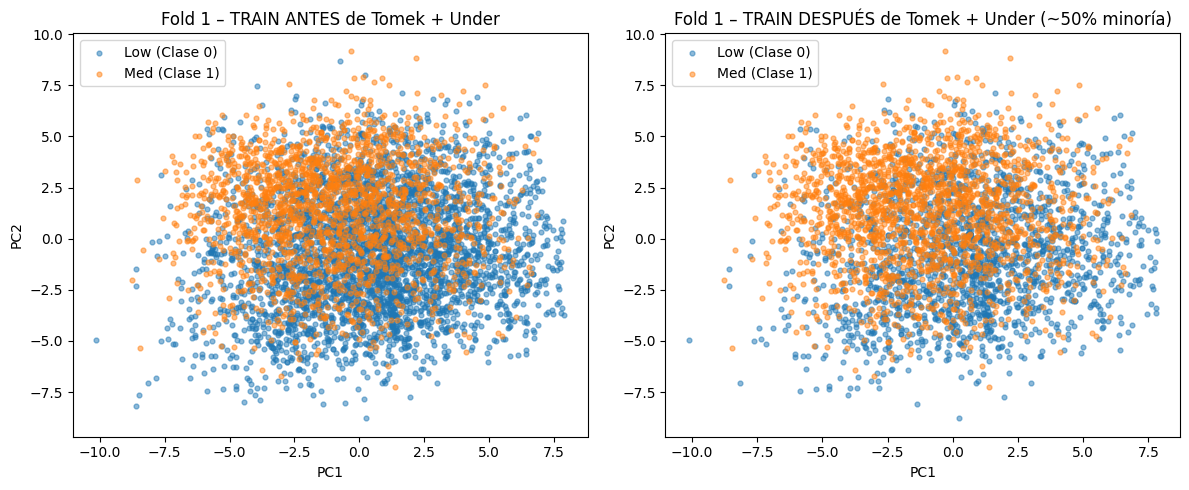

In [ ]:
# --- CELDA 5B: Visualizar Tomek + RandomUnderSampler dentro de un fold del CV (Low vs Med) ---

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
import numpy as np
import matplotlib.pyplot as plt

def _frac_to_ratio(f):
    """
    Convierte una fracción f = n_min / (n_min + n_maj)
    a razón sampling_strategy = n_min / n_maj.
    """
    return f / (1.0 - f)

# ------------------------------------------------------------------
# Supuestos:
#   - Xb, yb = dataset del duelo Low–Med ya filtrado.
#   - yb está codificada como 0 = Low, 1 = Med.
#   - RNG = random_state global (int).
# ------------------------------------------------------------------

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

# Tomamos SOLO el Fold 1 para visualizar qué pasa en un fold real
for fold_idx, (idx_tr, idx_va) in enumerate(skf.split(Xb, yb)):
    if fold_idx == 0:
        X_tr_fold = Xb.iloc[idx_tr]
        y_tr_fold = yb.iloc[idx_tr]
        X_va_fold = Xb.iloc[idx_va]
        y_va_fold = yb.iloc[idx_va]
        break

print("FOLD 1 - TRAIN antes del sampling:", np.bincount(y_tr_fold))
print("FOLD 1 - VALID (intacto, sin sampling):", np.bincount(y_va_fold))

# 1) Aplicar TomekLinks SOLO en el TRAIN del fold
tomek = TomekLinks(sampling_strategy='majority', n_jobs=-1)
X_tl, y_tl = tomek.fit_resample(X_tr_fold, y_tr_fold)

print("FOLD 1 - TRAIN después de TomekLinks:", np.bincount(y_tl))

# 2) Aplicar RandomUnderSampler para lograr ~50 de minoritaria
frac_min = 0.50
ratio_mm = _frac_to_ratio(frac_min)

under = RandomUnderSampler(sampling_strategy=ratio_mm, random_state=RNG)
X_bal, y_bal = under.fit_resample(X_tl, y_tl)

print("FOLD 1 - TRAIN después de Tomek + Under:", np.bincount(y_bal))

# 3) Reducir a 2D con PCA (ajustado en el TRAIN original del fold)
pca = PCA(n_components=2)
X2_before = pca.fit_transform(X_tr_fold)
X2_after  = pca.transform(X_bal)

# 4) Graficar antes y después (sólo TRAIN del fold)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# BEFORE
ax = axes[0]
ax.scatter(
    X2_before[y_tr_fold == 0, 0], X2_before[y_tr_fold == 0, 1],
    label="Low (Clase 0)", alpha=0.5, s=12
)
ax.scatter(
    X2_before[y_tr_fold == 1, 0], X2_before[y_tr_fold == 1, 1],
    label="Med (Clase 1)", alpha=0.5, s=12
)
ax.set_title("Fold 1 – TRAIN ANTES de Tomek + Under")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

# AFTER
ax = axes[1]
ax.scatter(
    X2_after[y_bal == 0, 0], X2_after[y_bal == 0, 1],
    label="Low (Clase 0)", alpha=0.5, s=12
)
ax.scatter(
    X2_after[y_bal == 1, 0], X2_after[y_bal == 1, 1],
    label="Med (Clase 1)", alpha=0.5, s=12
)
ax.set_title(f"Fold 1 – TRAIN DESPUÉS de Tomek + Under (~{int(frac_min*100)}% minoría)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

plt.tight_layout()
plt.show()


In [22]:
# --- CELDA 6: EJECUTAR MODELOS PARA DUELO Low–Med (CV mean ± sd, con SP) ---

from pathlib import Path
import pandas as pd
import json

REPORTS.mkdir(parents=True, exist_ok=True)

def run_low_med_cv(overwrite=False):
    """
    Ejecuta TODOS los MODELS en el duelo Low vs Medium,
    usando fit_eval_binary() con el MISMO esquema de muestreo
    que en la CELDA 5B (sampler_type="tomek_under", target_pos_ratio=0.44).

    Guarda:
      - __gridcv.xlsx  : resultados completos del GridSearchCV
      - __best.json    : mejores hiperparámetros + métricas CV (mean ± sd)
      - __tabla_CV.xlsx: resumen general tipo Tabla 3 (paper)

    Omite LGBM por coherencia con papers previos.
    """

    duel_name = "Low–Med"
    Xb, yb = make_low_vs_med(X, y)

    print(f"\n=== {duel_name} ===  X={Xb.shape}  pos={int(yb.sum())}  neg={len(yb)-int(yb.sum())}")

    rows = []

    PRETTY = {
        "accuracy":   "ACC",
        "recall":     "RC",
        "precision":  "PR",
        "f1":         "F1S",
        "specificity":"SP",
        "roc_auc":    "AUC",
    }

    for model_key, model in MODELS.items():

        if model_key in {"LGBM"}:
            print(f"  > {model_key} (omitido por configuración)")
            continue

        base = REPORTS / f"{duel_name}__{model_key}"
        grid_path = base.with_name(base.name + "__gridcv.xlsx")
        best_path = base.with_name(base.name + "__best.json")

        # Si no queremos re-ejecutar
        if (not overwrite) and best_path.exists():
            print(f"  > {model_key} (saltando, ya existe)")
            best = json.loads(best_path.read_text(encoding="utf-8"))

        else:
            print(f"  > {model_key} ...")

            # MISMO SAMPLING QUE CELDA 5B
            resumen, gs, _, _ = fit_eval_binary(
                model,
                GRIDS[model_key],
                Xb,
                yb,
                label_name=f"{duel_name} · {model_key}",
                sampler_type="tomek_under",   # <<< TomekLinks + Under
                target_pos_ratio=0.50,        # <<< minoría deseada
                log_counts=True
            )

            # guarda grid completo
            pd.DataFrame(gs.cv_results_).to_excel(grid_path, index=False)

            # limpia parámetros del pipeline
            def _clean_params(d):
                out = {}
                for k, v in d.items():
                    k = k.replace("clf__", "")
                    if hasattr(v, "item"):
                        v = v.item()
                    out[k] = v
                return out

            idx = gs.best_index_

            # extrae métricas CV mean ± sd
            cv_metrics = {}
            for m in SCORING:
                mean = gs.cv_results_[f"mean_test_{m}"][idx]
                sd   = gs.cv_results_[f"std_test_{m}"][idx]
                pretty = PRETTY[m]
                cv_metrics[pretty] = f"{mean:.4f} ± {sd:.4f}"

            best = {
                "Duelo": duel_name,
                "Modelo": model_key,
                "params": _clean_params(gs.best_params_),
                **cv_metrics
            }

            best_path.write_text(json.dumps(best, ensure_ascii=False, indent=2), encoding="utf-8")

        # fila resumen final
        row = {"Duelo": duel_name, "Modelo": model_key}
        for m in ("ACC","RC","F1S","PR","SP","AUC"):
            row[m] = best.get(m, "—")
        rows.append(row)

    df = pd.DataFrame(rows).sort_values(["Duelo","Modelo"]).reset_index(drop=True)
    out_tab = REPORTS / f"{duel_name}__tabla_CV.xlsx"
    df.to_excel(out_tab, index=False)

    print("✅ Guardado resumen de CV en:", out_tab)
    return df


In [23]:
# --- EJECUTAR EL DUELO LOW–MED ---
df_cv = run_low_med_cv(overwrite=True)
df_cv


Binario: Low (0) vs Medium (1)
X=(6942, 68), total=6942
Low (0): 4590
Medium (1): 2352
Proporción Medium (1): 0.339

=== Low–Med ===  X=(6942, 68)  pos=2352  neg=4590
  > LR ...

=== SPLIT (estratificado) ===
TRAIN: n0=3672 (0.661) | n1=1881 (0.339) | total=5553
 TEST: n0=918 (0.661) | n1=471 (0.339) | total=1389

=== DISTRIBUCIONES POR FOLD (antes y después de TOMEK_UNDER) ===
[Fold 1] BEFORE: n0=2937 (0.661) | n1=1505 (0.339) | total=4442
             AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 2] BEFORE: n0=2937 (0.661) | n1=1505 (0.339) | total=4442
             AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 3] BEFORE: n0=2938 (0.661) | n1=1504 (0.339) | total=4442
             AFTER : n0=1504 (0.500) | n1=1504 (0.500) | total=3008  -> f_min≈0.50
[Fold 4] BEFORE: n0=2938 (0.661) | n1=1505 (0.339) | total=4443
             AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 5] BEFORE: n0=2938 (0.661

UnboundLocalError: cannot access local variable 'pid' where it is not associated with a value

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=True)


{'status': 'ok', 'restart': True}

: 

In [ ]:
# --- CELDA 7: Stacking como un modelo más (compatible con Celda 5 y 6) ---

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def build_stacking_estimator(rng=RNG, incluir_svm=True):
    """
    Crea un StackingClassifier con varios modelos base y meta-learner LR.
    El balanceo (under/SMOTETomek) se aplica FUERA, en la Celda 5, antes del paso 'clf'.
    """
    bases = [
        ("LR",  clone(MODELS["LR"])),
        ("DT",  clone(MODELS["DT"])),
        ("RF",  clone(MODELS["RF"])),
        ("GB",  clone(MODELS["GB"])),
        ("XGB", clone(MODELS["XGB"])),
        ("MLP", clone(MODELS["MLP"])),
    ]
    if incluir_svm:
        bases.insert(1, ("SVM", clone(MODELS["SVM"])))  # opcional (puede ser lento)

    meta = LogisticRegression(max_iter=1000, random_state=rng)

    stack = StackingClassifier(
        estimators=bases,
        final_estimator=meta,
        stack_method="predict_proba",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rng),  # OOF interno del stack
        n_jobs=-1,
        passthrough=False
    )
    return stack

# Instancia del stack y su grid (¡ojo con el prefijo 'clf__' porque el stack va en el paso 'clf'!)
STACK_MODEL = build_stacking_estimator(rng=RNG, incluir_svm=True)  # pon True si quieres SVM base
GRIDS["STACK"] = {
    "clf__final_estimator__solver":  ["liblinear", "saga"],
    "clf__final_estimator__penalty": ["l1", "l2"],
    "clf__final_estimator__C":       [0.1, 1, 10, 100],
}
MODELS["STACK"] = STACK_MODEL


df_cv = run_low_med_cv(overwrite=False)  # ahora incluirá "STACK" en la tabla
df_cv


Binario: Low (0) vs Medium (1)
X=(6942, 68), total=6942
Low (0): 4590
Medium (1): 2352
Proporción Medium (1): 0.339

=== Low–Med ===  X=(6942, 68)  pos=2352  neg=4590
  > LR (saltando, ya existe)
  > SVM (saltando, ya existe)
  > DT (saltando, ya existe)
  > RF (saltando, ya existe)
  > GB (saltando, ya existe)
  > XGB (saltando, ya existe)
  > LGBM (omitido por configuración)
  > MLP (saltando, ya existe)
  > STACK (saltando, ya existe)
✅ Guardado resumen de CV en: c:\Users\Gerson\Downloads\PISA-ML\reports\tables\Low–Med__tabla_CV.xlsx


,Duelo,Modelo,ACC,RC,F1S,PR,SP,AUC
0,Low–Med,DT,0.7074 ± 0.0083,0.7236 ± 0.0335,0.6259 ± 0.0147,0.5520 ± 0.0097,0.6991 ± 0.0172,0.7774 ± 0.0134
1,Low–Med,GB,0.7607 ± 0.0108,0.7985 ± 0.0101,0.6934 ± 0.0102,0.6129 ± 0.0146,0.7413 ± 0.0165,0.8549 ± 0.0099
2,Low–Med,LR,0.7538 ± 0.0153,0.7831 ± 0.0179,0.6832 ± 0.0152,0.6063 ± 0.0197,0.7388 ± 0.0226,0.8445 ± 0.0112
3,Low–Med,MLP,0.7522 ± 0.0171,0.7847 ± 0.0182,0.6823 ± 0.0145,0.6043 ± 0.0228,0.7356 ± 0.0293,0.8447 ± 0.0110
4,Low–Med,RF,0.7475 ± 0.0126,0.7767 ± 0.0193,0.6758 ± 0.0131,0.5985 ± 0.0160,0.7326 ± 0.0192,0.8368 ± 0.0112
5,Low–Med,STACK,0.7664 ± 0.0118,0.7847 ± 0.0176,0.6948 ± 0.0127,0.6237 ± 0.0161,0.7571 ± 0.0177,0.8553 ± 0.0108
6,Low–Med,SVM,0.7540 ± 0.0127,0.7879 ± 0.0198,0.6846 ± 0.0140,0.6055 ± 0.0158,0.7367 ± 0.0179,0.8440 ± 0.0115
7,Low–Med,XGB,0.7517 ± 0.0108,0.7815 ± 0.0156,0.6808 ± 0.0111,0.6033 ± 0.0145,0.7364 ± 0.0170,0.8472 ± 0.0111


In [25]:
# si falta, define/redefine el grid del meta-estimador LR
GRIDS["STACK"] = {
    "clf__final_estimator__solver":  ["liblinear", "saga"],
    "clf__final_estimator__penalty": ["l1", "l2"],
    "clf__final_estimator__C":       [0.1, 1, 10, 100],
}
print("MODELS keys:", list(MODELS.keys()))
print("GRIDS  keys:", list(GRIDS.keys()))


MODELS keys: ['LR', 'SVM', 'DT', 'RF', 'GB', 'XGB', 'LGBM', 'MLP', 'STACK']
GRIDS  keys: ['LR', 'SVM', 'DT', 'RF', 'GB', 'XGB', 'LGBM', 'MLP', 'STACK']


In [48]:
# --- CELDA 8: Métricas por clase para TODOS los modelos (excepto SVM, STACK y LGBM) ---

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def per_class_metrics_from_cm(y_true, y_pred):
    """
    Calcula métricas por clase a partir de la matriz de confusión binaria.
    Asume etiquetas 0 (Low) y 1 (Med).

    Para cada clase c∈{0,1} se calcula:
      - ACC_c : accuracy global (es la misma para ambas clases, pero se replica por simetría)
      - PR_c  : precisión de la clase c (tratándola como 'positiva')
      - RC_c  : recall/sensibilidad de la clase c
      - F1_c  : F1-score de la clase c
      - SP_c  : especificidad respecto a la clase c (es decir, cómo identifica "no-c")
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    total = tn + fp + fn + tp
    acc = (tn + tp) / total if total > 0 else 0.0

    # --- Clase 1 (Med) -> la "positiva" estándar ---
    TP1, FN1, FP1, TN1 = tp, fn, fp, tn
    pr_1 = TP1 / (TP1 + FP1) if (TP1 + FP1) > 0 else 0.0
    rc_1 = TP1 / (TP1 + FN1) if (TP1 + FN1) > 0 else 0.0  # sensibilidad
    sp_1 = TN1 / (TN1 + FP1) if (TN1 + FP1) > 0 else 0.0  # especificidad
    f1_1 = 2 * pr_1 * rc_1 / (pr_1 + rc_1) if (pr_1 + rc_1) > 0 else 0.0

    # --- Clase 0 (Low) -> la tratamos como "positiva" intercambiando roles ---
    TP0, FN0, FP0, TN0 = tn, fp, fn, tp
    pr_0 = TP0 / (TP0 + FP0) if (TP0 + FP0) > 0 else 0.0
    rc_0 = TP0 / (TP0 + FN0) if (TP0 + FN0) > 0 else 0.0
    sp_0 = TN0 / (TN0 + FP0) if (TN0 + FP0) > 0 else 0.0
    f1_0 = 2 * pr_0 * rc_0 / (pr_0 + rc_0) if (pr_0 + rc_0) > 0 else 0.0

    return {
        # Métricas por clase 0 (Low)
        "ACC_0": acc,
        "PR_0":  pr_0,
        "RC_0":  rc_0,
        "F1_0":  f1_0,
        "SP_0":  sp_0,

        # Métricas por clase 1 (Med)
        "ACC_1": acc,
        "PR_1":  pr_1,
        "RC_1":  rc_1,
        "F1_1":  f1_1,
        "SP_1":  sp_1,
    }

def build_class_metrics_for_model(model_key, Xb, yb, duel_name="Low–Med"):
    """
    - Entrena y evalúa el modelo 'model_key' con fit_eval_binary (CV interna).
    - Usa umbral t=0.5 para predecir en TEST.
    - Calcula métricas globales (compute_metrics) y métricas por clase.
    NO busca umbral óptimo, NO dibuja matrices, NO guarda archivos.
    """
    print(f"\n=== {duel_name} · {model_key} — métricas por clase (t=0.5) ===")

    # Entrenar con el esquema normal (híbrido 0.50 que ya tienes por defecto)
    resumen, gs, y_te, proba = fit_eval_binary(
        MODELS[model_key],
        GRIDS[model_key],
        Xb,
        yb,
        label_name=f"{duel_name} · {model_key}",
        log_counts=False  # sampler_type y target_pos_ratio usan los defaults
    )

    # Predicción con t=0.5
    y_pred = (proba >= 0.5).astype(int)

    # Métricas globales (las de siempre: ACC, RC, PR, F1S, SP, AUC)
    met_global = compute_metrics(y_te, y_pred, proba)

    # Métricas por clase (0=Low, 1=Med)
    met_per_class = per_class_metrics_from_cm(y_te, y_pred)

    # Print rápido para inspección
    print(
        f"Global => ACC={met_global['ACC']:.3f} | F1S={met_global['F1S']:.3f} | "
        f"RC={met_global['RC']:.3f} | PR={met_global['PR']:.3f} | "
        f"SP={met_global['SP']:.3f} | AUC={met_global['AUC']:.3f}"
    )
    print(
        f"Clase 0 (Low) => "
        f"ACC_0={met_per_class['ACC_0']:.3f} | PR_0={met_per_class['PR_0']:.3f} | "
        f"RC_0={met_per_class['RC_0']:.3f} | F1_0={met_per_class['F1_0']:.3f} | "
        f"SP_0={met_per_class['SP_0']:.3f}"
    )
    print(
        f"Clase 1 (Med) => "
        f"ACC_1={met_per_class['ACC_1']:.3f} | PR_1={met_per_class['PR_1']:.3f} | "
        f"RC_1={met_per_class['RC_1']:.3f} | F1_1={met_per_class['F1_1']:.3f} | "
        f"SP_1={met_per_class['SP_1']:.3f}"
    )

    # Unir todo en un solo dict para el DataFrame final
    out = {
        "Modelo": model_key,
        # métricas globales
        "ACC":  met_global["ACC"],
        "F1S":  met_global["F1S"],
        "RC":   met_global["RC"],
        "PR":   met_global["PR"],
        "SP":   met_global["SP"],
        "AUC":  met_global["AUC"],
    }
    # métricas por clase
    out.update(met_per_class)
    return out

def run_per_class_all_models(Xb, yb, model_keys=None, duel_name="Low–Med"):
    """
    Ejecuta métricas por clase para varios modelos.

    Por defecto: TODOS los modelos en MODELS excepto:
      - 'SVM'
      - 'STACK'
      - 'LGBM'
    """
    if model_keys is None:
        exclude = {"LGBM"}
        model_keys = [k for k in MODELS.keys() if k not in exclude]

    print("Modelos a ejecutar (métricas por clase):", model_keys)
    rows = []
    for mk in model_keys:
        try:
            rows.append(build_class_metrics_for_model(mk, Xb, yb, duel_name=duel_name))
        except Exception as e:
            print(f"(Saltando {mk} por error): {e}")

    df = pd.DataFrame(rows).sort_values("Modelo").reset_index(drop=True)
    return df

# === Ejecución sobre el duelo actual (Low–Med) ===
df_per_class = run_per_class_all_models(Xb, yb, duel_name="Low–Med")
df_per_class


Modelos a ejecutar (métricas por clase): ['LR', 'SVM', 'DT', 'RF', 'GB', 'XGB', 'MLP', 'STACK']

=== Low–Med · LR — métricas por clase (t=0.5) ===
Global => ACC=0.752 | F1S=0.674 | RC=0.756 | PR=0.609 | SP=0.751 | AUC=0.850
Clase 0 (Low) => ACC_0=0.752 | PR_0=0.857 | RC_0=0.751 | F1_0=0.800 | SP_0=0.756
Clase 1 (Med) => ACC_1=0.752 | PR_1=0.609 | RC_1=0.756 | F1_1=0.674 | SP_1=0.751

=== Low–Med · SVM — métricas por clase (t=0.5) ===
Global => ACC=0.752 | F1S=0.676 | RC=0.762 | PR=0.607 | SP=0.747 | AUC=0.848
Clase 0 (Low) => ACC_0=0.752 | PR_0=0.860 | RC_0=0.747 | F1_0=0.800 | SP_0=0.762
Clase 1 (Med) => ACC_1=0.752 | PR_1=0.607 | RC_1=0.762 | F1_1=0.676 | SP_1=0.747

=== Low–Med · DT — métricas por clase (t=0.5) ===
Global => ACC=0.701 | F1S=0.612 | RC=0.694 | PR=0.547 | SP=0.705 | AUC=0.770
Clase 0 (Low) => ACC_0=0.701 | PR_0=0.818 | RC_0=0.705 | F1_0=0.757 | SP_0=0.694
Clase 1 (Med) => ACC_1=0.701 | PR_1=0.547 | RC_1=0.694 | F1_1=0.612 | SP_1=0.705

=== Low–Med · RF — métricas por 

C:\Users\Gerson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:05:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Global => ACC=0.770 | F1S=0.695 | RC=0.775 | PR=0.630 | SP=0.767 | AUC=0.854
Clase 0 (Low) => ACC_0=0.770 | PR_0=0.869 | RC_0=0.767 | F1_0=0.815 | SP_0=0.775
Clase 1 (Med) => ACC_1=0.770 | PR_1=0.630 | RC_1=0.775 | F1_1=0.695 | SP_1=0.767

=== Low–Med · MLP — métricas por clase (t=0.5) ===


C:\Users\Gerson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Global => ACC=0.749 | F1S=0.681 | RC=0.792 | PR=0.598 | SP=0.727 | AUC=0.833
Clase 0 (Low) => ACC_0=0.749 | PR_0=0.872 | RC_0=0.727 | F1_0=0.793 | SP_0=0.792
Clase 1 (Med) => ACC_1=0.749 | PR_1=0.598 | RC_1=0.792 | F1_1=0.681 | SP_1=0.727

=== Low–Med · STACK — métricas por clase (t=0.5) ===
Global => ACC=0.762 | F1S=0.681 | RC=0.749 | PR=0.625 | SP=0.769 | AUC=0.859
Clase 0 (Low) => ACC_0=0.762 | PR_0=0.857 | RC_0=0.769 | F1_0=0.811 | SP_0=0.749
Clase 1 (Med) => ACC_1=0.762 | PR_1=0.625 | RC_1=0.749 | F1_1=0.681 | SP_1=0.769


,Modelo,ACC,F1S,RC,PR,SP,AUC,ACC_0,PR_0,RC_0,F1_0,SP_0,ACC_1,PR_1,RC_1,F1_1,SP_1
0,DT,0.701224,0.611787,0.694268,0.546823,0.704793,0.770159,0.701224,0.817952,0.704793,0.757168,0.694268,0.701224,0.546823,0.694268,0.611787,0.704793
1,GB,0.769618,0.694656,0.772824,0.630849,0.767974,0.857067,0.769618,0.868227,0.767974,0.815029,0.772824,0.769618,0.630849,0.772824,0.694656,0.767974
2,LR,0.752340,0.674242,0.755839,0.608547,0.750545,0.850180,0.752340,0.856965,0.750545,0.800232,0.755839,0.752340,0.608547,0.755839,0.674242,0.750545
3,MLP,0.748740,0.681279,0.791932,0.597756,0.726580,0.832778,0.748740,0.871895,0.726580,0.792632,0.791932,0.748740,0.597756,0.791932,0.681279,0.726580
4,RF,0.751620,0.677871,0.770701,0.605000,0.741830,0.842278,0.751620,0.863118,0.741830,0.797891,0.770701,0.751620,0.605000,0.770701,0.677871,0.741830
5,STACK,0.762419,0.681467,0.749469,0.624779,0.769063,0.858892,0.762419,0.856796,0.769063,0.810563,0.749469,0.762419,0.624779,0.749469,0.681467,0.769063
6,SVM,0.752340,0.676083,0.762208,0.607445,0.747277,0.848453,0.752340,0.859649,0.747277,0.799534,0.762208,0.752340,0.607445,0.762208,0.676083,0.747277
7,XGB,0.769618,0.695238,0.774947,0.630397,0.766885,0.853539,0.769618,0.869136,0.766885,0.814815,0.774947,0.769618,0.630397,0.774947,0.695238,0.766885


In [49]:
# --- CELDA 9 NUEVA Y COMPLETA: Matrices de confusión para TODOS los modelos ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score

REPORTS.mkdir(exist_ok=True, parents=True)

# ---------------------------------------------------
#  Funciones internas para esta celda
# ---------------------------------------------------

def compute_metrics_simple(y_true, y_pred, proba):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    pr  = tp / (tp + fp) if (tp + fp) > 0 else 0
    rc  = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1  = 2 * pr * rc / (pr + rc) if (pr + rc) > 0 else 0
    sp  = tn / (tn + fp) if (tn + fp) > 0 else 0
    auc = roc_auc_score(y_true, proba)
    
    return {"ACC":acc, "PR":pr, "RC":rc, "F1S":f1, "SP":sp, "AUC":auc}


def optimize_threshold(y_true, proba):
    best_t = 0.5
    best_f1 = 0
    for t in np.linspace(0.05, 0.95, 91):
        y_pred = (proba >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        pr = tp / (tp + fp) if (tp + fp) > 0 else 0
        rc = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * pr * rc / (pr + rc) if (pr + rc) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t


def plot_confusion(ax, cm, title):
    ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0 (Low)", "Pred 1 (Med)"], rotation=15)
    ax.set_yticklabels(["True 0 (Low)", "True 1 (Med)"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=10)


# ---------------------------------------------------
#  EJECUCIÓN PARA TODOS LOS MODELOS
# ---------------------------------------------------

results = []

print("Modelos a ejecutar:", list(MODELS.keys()))

for model_key in MODELS.keys():
    print(f"\n🟦 Ejecutando modelo: {model_key}")

    # Entrenamiento + CV + sampler usando tu función estándar
    resumen, gs, y_te, proba = fit_eval_binary(
        MODELS[model_key],
        GRIDS[model_key],
        Xb,
        yb,
        label_name=f"Conf {model_key}",
        log_counts=False
    )

    # Predicción default
    y_pred_default = (proba >= 0.5).astype(int)
    met_default = compute_metrics_simple(y_te, y_pred_default, proba)
    cm_default = confusion_matrix(y_te, y_pred_default)

    # Umbral óptimo
    t_opt = optimize_threshold(y_te, proba)
    y_pred_opt = (proba >= t_opt).astype(int)
    met_opt = compute_metrics_simple(y_te, y_pred_opt, proba)
    cm_opt = confusion_matrix(y_te, y_pred_opt)

    # PNG
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_confusion(axes[0], cm_default, f"{model_key} (t=0.5)")
    plot_confusion(axes[1], cm_opt, f"{model_key} (t={t_opt:.2f})")
    plt.tight_layout()

    png_path = REPORTS / f"{model_key}__confusion.png"
    plt.savefig(png_path, dpi=150)
    plt.close(fig)

    # XLSX
    df_cm_default = pd.DataFrame(cm_default, columns=["Pred 0", "Pred 1"], index=["True 0", "True 1"])
    df_cm_opt     = pd.DataFrame(cm_opt,     columns=["Pred 0", "Pred 1"], index=["True 0", "True 1"])

    df_out = pd.concat({"default": df_cm_default, "opt": df_cm_opt})
    xlsx_path = REPORTS / f"{model_key}__confusion.xlsx"
    df_out.to_excel(xlsx_path)

    # Agregar al resumen
    results.append({
        "Modelo": model_key,
        "t*": t_opt,
        "ACC (0.5)": met_default["ACC"],
        "ACC (t*)":  met_opt["ACC"],
        "F1 (0.5)":  met_default["F1S"],
        "F1 (t*)":   met_opt["F1S"],
        "AUC":       met_opt["AUC"],
        "PNG":       str(png_path),
        "XLSX":      str(xlsx_path)
    })

# ---------------------------------------------------
#  CREAR TABLA RESUMEN
# ---------------------------------------------------

df_conf = pd.DataFrame(results).sort_values("AUC", ascending=False).reset_index(drop=True)
out_tab = REPORTS / "Low-Med__confusions__TODOS.xlsx"
df_conf.to_excel(out_tab, index=False)

print(f"\n✅ Resumen guardado en: {out_tab}")
df_conf


Modelos a ejecutar: ['LR', 'SVM', 'DT', 'RF', 'GB', 'XGB', 'LGBM', 'MLP', 'STACK']

🟦 Ejecutando modelo: LR

🟦 Ejecutando modelo: SVM

🟦 Ejecutando modelo: DT

🟦 Ejecutando modelo: RF

🟦 Ejecutando modelo: GB

🟦 Ejecutando modelo: XGB


C:\Users\Gerson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:35:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🟦 Ejecutando modelo: LGBM
[LightGBM] [Info] Number of positive: 1881, number of negative: 1881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 3762, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🟦 Ejecutando modelo: MLP


C:\Users\Gerson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



🟦 Ejecutando modelo: STACK

✅ Resumen guardado en: c:\Users\Gerson\Downloads\PISA-ML\reports\tables\Low-Med__confusions__TODOS.xlsx


,Modelo,t*,ACC (0.5),ACC (t*),F1 (0.5),F1 (t*),AUC,PNG,XLSX
0,STACK,0.38,0.762419,0.751620,0.681467,0.698690,0.858892,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
1,GB,0.49,0.769618,0.771778,0.694656,0.701787,0.857067,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
2,LGBM,0.42,0.776098,0.764579,0.703527,0.708296,0.854412,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
3,XGB,0.48,0.769618,0.768179,0.695238,0.700186,0.853539,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
4,LR,0.54,0.752340,0.773218,0.674242,0.689042,0.850180,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
5,SVM,0.40,0.752340,0.732901,0.676083,0.683717,0.848453,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
6,RF,0.49,0.751620,0.749460,0.677871,0.678373,0.842278,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
7,MLP,0.57,0.748740,0.762419,0.681279,0.687500,0.832778,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...
8,DT,0.44,0.701224,0.691865,0.611787,0.623239,0.770159,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...,c:\Users\Gerson\Downloads\PISA-ML\reports\tabl...


In [30]:
# --- CELDA A: Entrenar SOLO STACK con Tomek+Under (Low–Med) ---

# 1) Duelo Low vs Med
Xb_full, yb = make_low_vs_med(X, y)

print("Binario Low–Med")
print("Xb_full.shape:", Xb_full.shape)
print("Conteo clases:\n", yb.value_counts().sort_index(), "\n")

FINAL_SAMPLER   = "tomek_under"   # lo que ya estás usando
TARGET_MINORITY = 0.50            # o 0.50 si esa es tu versión final

res_stack, gs_stack, y_te_stack, proba_stack = fit_eval_binary(
    model=MODELS["STACK"],       # 🔁 ahora usamos STACK
    grid=GRIDS["STACK"],
    Xb=Xb_full,
    yb=yb,
    test_size=0.2,
    rng=RNG,
    label_name="Low–Med · STACK (TomekUnder)",
    target_pos_ratio=TARGET_MINORITY,
    sampler_type=FINAL_SAMPLER,
    log_counts=True
)

print("\nResumen CV+TEST STACK (Tomek+Under):")
for k, v in res_stack.items():
    print(f"{k}: {v}")

# Pipeline final (sampler + STACK) que usaremos para SHAP
STACK_PIPE = gs_stack.best_estimator_


Binario: Low (0) vs Medium (1)
X=(6942, 68), total=6942
Low (0): 4590
Medium (1): 2352
Proporción Medium (1): 0.339
Binario Low–Med
Xb_full.shape: (6942, 68)
Conteo clases:
 MATH_LEVEL_3CAT
0    4590
1    2352
Name: count, dtype: int64 


=== SPLIT (estratificado) ===
TRAIN: n0=3672 (0.661) | n1=1881 (0.339) | total=5553
 TEST: n0=918 (0.661) | n1=471 (0.339) | total=1389

=== DISTRIBUCIONES POR FOLD (antes y después de TOMEK_UNDER) ===
[Fold 1] BEFORE: n0=2937 (0.661) | n1=1505 (0.339) | total=4442
             AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 2] BEFORE: n0=2937 (0.661) | n1=1505 (0.339) | total=4442
             AFTER : n0=1505 (0.500) | n1=1505 (0.500) | total=3010  -> f_min≈0.50
[Fold 3] BEFORE: n0=2938 (0.661) | n1=1504 (0.339) | total=4442
             AFTER : n0=1504 (0.500) | n1=1504 (0.500) | total=3008  -> f_min≈0.50
[Fold 4] BEFORE: n0=2938 (0.661) | n1=1505 (0.339) | total=4443
             AFTER : n0=1505 (0.500) | n1=1505 (0.500)

In [33]:
# --- CELDA A2: Split Train/Test para Low–Med ---

from sklearn.model_selection import train_test_split

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb_full, yb,
    test_size=0.20,
    shuffle=True,
    stratify=yb,
    random_state=RNG   # mismo RNG que usas en fit_eval_binary
)

print("TRAIN:", Xb_train.shape, yb_train.shape)
print("TEST :", Xb_test.shape,  yb_test.shape)
print("y_train:", yb_train.value_counts().sort_index().to_dict())
print("y_test :", yb_test.value_counts().sort_index().to_dict())


TRAIN: (5553, 68) (5553,)
TEST : (1389, 68) (1389,)
y_train: {0: 3672, 1: 1881}
y_test : {0: 918, 1: 471}


In [50]:
# --- CELDA B: SHAP para STACK (Low–Med, Tomek+Under) ---

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Usaremos el mismo Xb_full
X_explain = Xb_full.copy()
print("Usando", X_explain.shape[0], "filas para SHAP (todas).")

# Convertimos a matriz NumPy float para evitar problemas con isfinite
X_explain_np = X_explain.to_numpy(dtype=float)

# Submuestra de background para el explainer (más ligero)
N_BACKGROUND = 300
rng = np.random.default_rng(42)

idx_bg = rng.choice(
    X_explain_np.shape[0],
    size=min(N_BACKGROUND, X_explain_np.shape[0]),
    replace=False
)
X_bg_np = X_explain_np[idx_bg, :]

# Función que recibe array NumPy y lo convierte a DataFrame
def stack_proba_pos(data_np):
    df_tmp = pd.DataFrame(data_np, columns=X_explain.columns)
    return STACK_PIPE.predict_proba(df_tmp)[:, 1]  # clase positiva = 1 (Med)

# Explainer genérico sobre la probabilidad de la clase positiva
explainer = shap.Explainer(stack_proba_pos, X_bg_np)

# Obtenemos las explicaciones SHAP sobre TODO X_explain_np
sv_stack = explainer(X_explain_np)   # shap.Explanation

# Importancia global: media del |SHAP| por feature
mean_abs_shap = np.abs(sv_stack.values).mean(axis=0)

df_shap_import = pd.DataFrame({
    "feature": Xb_full.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

display(df_shap_import.head(20))

# Guardar ranking completo
out_shap = REPORTS / "Low-Med__STACK__SHAP_importance.xlsx"
df_shap_import.to_excel(out_shap, index=False)
print("✅ Importancias SHAP guardadas en:", out_shap)

# Gráficos globales rápidos (sin guardar aún)
plt.figure()
shap.summary_plot(sv_stack.values, X_explain, show=False)  # usamos DataFrame para nombres
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(sv_stack.values, X_explain, plot_type="bar", show=False)
plt.tight_layout()
plt.show()


Usando 6942 filas para SHAP (todas).


KeyboardInterrupt: 

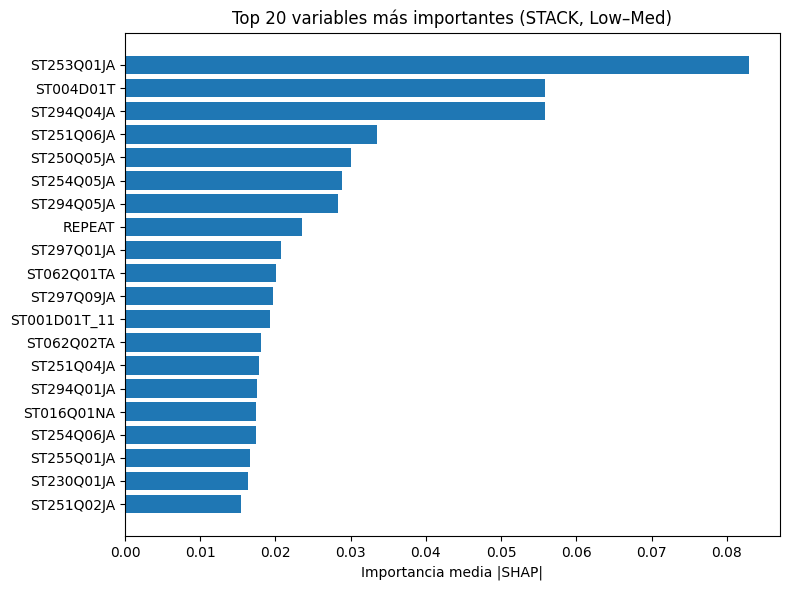

In [ ]:
#CELDA DE BARPLOT
import pandas as pd
import matplotlib.pyplot as plt

df_shap_import = pd.read_excel(REPORTS / "Low-Med__STACK__SHAP_importance.xlsx")

top20 = df_shap_import.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20["feature"], top20["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia media |SHAP|")
plt.title("Top 20 variables más importantes (STACK, Low–Med)")
plt.tight_layout()
plt.savefig("SHAP_bar_GLOBAL.png", dpi=300)
plt.show()


Tamaño usado para SHAP rápido: (1000, 68)


PermutationExplainer explainer: 1001it [3:27:37, 12.47s/it]                           
C:\Users\Gerson\AppData\Local\Temp\ipykernel_27580\532324465.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


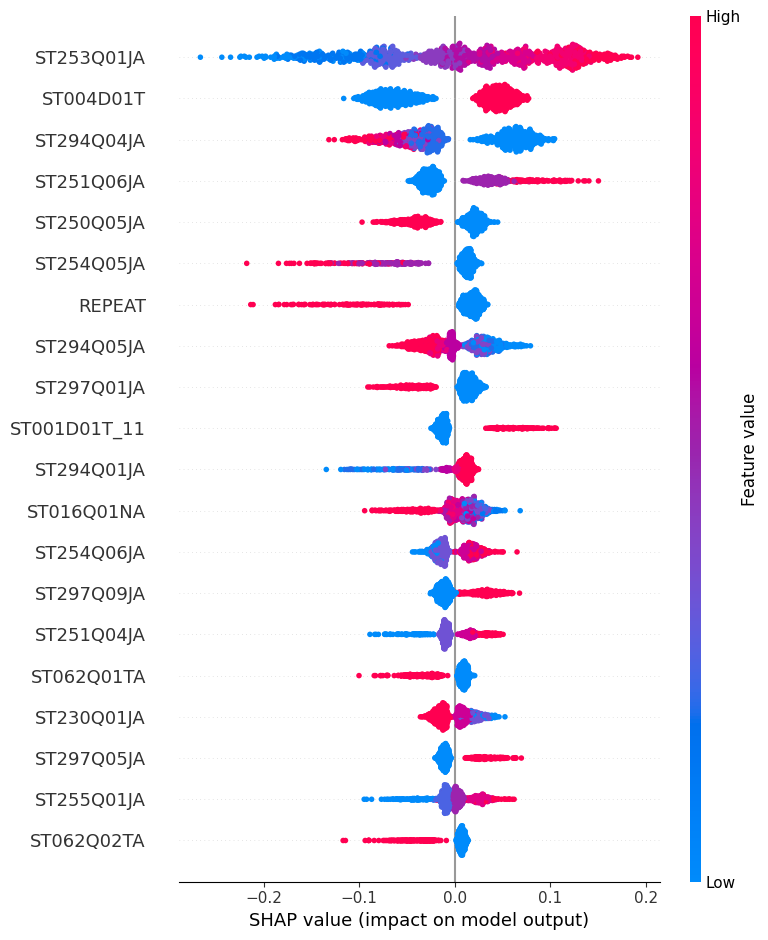

🎉 Gráfico SHAP regenerado y guardado como: SHAP_summary_FULL_FAST.png


In [52]:
# --- SHAP SUMMARY PLOT COMPLETO (REGENERADO RÁPIDO) ---
# Usando una submuestra suficientemente grande para reproducir
# el gráfico original sin 13 horas de cómputo.

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Tomar una submuestra grande que sea representativa
N = 1000  # puedes subir a 1500 si quieres
rng = np.random.default_rng(42)

idx = rng.choice(Xb_full.shape[0], size=min(N, Xb_full.shape[0]), replace=False)
X_explain = Xb_full.iloc[idx].copy()
X_explain_np = X_explain.to_numpy(dtype=float)

print("Tamaño usado para SHAP rápido:", X_explain.shape)

# 2. Background pequeño
N_BG = 120
idx_bg = rng.choice(X_explain_np.shape[0], size=min(N_BG, X_explain_np.shape[0]), replace=False)
X_bg_np = X_explain_np[idx_bg]

def stack_proba_pos(data_np):
    df_tmp = pd.DataFrame(data_np, columns=X_explain.columns)
    return STACK_PIPE.predict_proba(df_tmp)[:, 1]

# 3. SHAP rápido
explainer_fast = shap.Explainer(stack_proba_pos, X_bg_np)
sv_fast = explainer_fast(X_explain_np)

# 4. SUMMARY PLOT (como el que perdiste)
plt.figure(figsize=(11, 9))
shap.summary_plot(
    sv_fast.values,
    X_explain,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.savefig("SHAP_summary_FULL_FAST.png", dpi=300)
plt.show()

print("🎉 Gráfico SHAP regenerado y guardado como: SHAP_summary_FULL_FAST.png")


Número total de variables: 68
k=  1 | ACC=0.6919 | AUC=0.7451
k=  5 | ACC=0.7185 | AUC=0.7842
k= 10 | ACC=0.7415 | AUC=0.8240
k= 15 | ACC=0.7394 | AUC=0.8302
k= 20 | ACC=0.7552 | AUC=0.8464
k= 25 | ACC=0.7610 | AUC=0.8544
k= 35 | ACC=0.7595 | AUC=0.8548
k= 50 | ACC=0.7639 | AUC=0.8590
k= 68 | ACC=0.7617 | AUC=0.8599


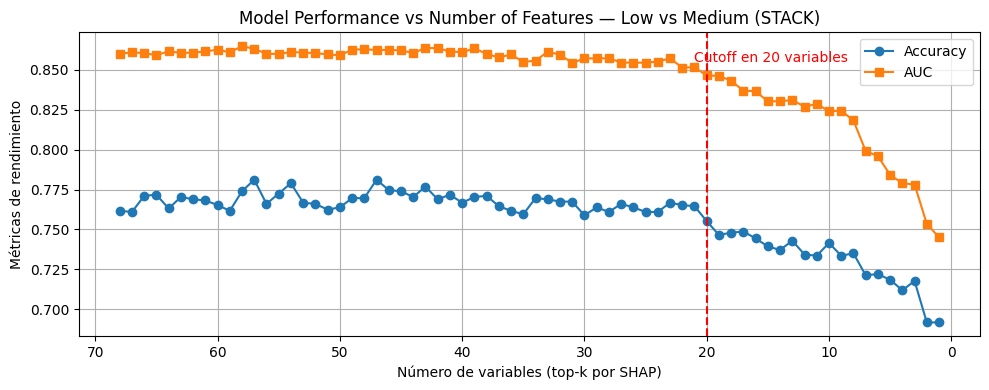

In [32]:
# --- CELDA C: Rendimiento vs nº de variables (Low–Med, STACK) ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score, roc_auc_score

# Ranking SHAP de la Celda B
ordered_feats = df_shap_import["feature"].tolist()
n_feats = len(ordered_feats)
print(f"Número total de variables: {n_feats}")

acc_list, auc_list, k_list = [], [], []

for k in range(1, n_feats + 1):
    feats_k = ordered_feats[:k]

    Xtr_k = Xb_train[feats_k]
    Xte_k = Xb_test[feats_k]

    # clonamos tu pipeline final (STACK + Tomek+Under)
    model_k = clone(STACK_PIPE)
    model_k.fit(Xtr_k, yb_train)

    proba = model_k.predict_proba(Xte_k)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(yb_test, y_pred)
    auc = roc_auc_score(yb_test, proba)

    acc_list.append(acc)
    auc_list.append(auc)
    k_list.append(k)

    if k in [1, 5, 10, 15, 20, 25, 35, 50, n_feats]:
        print(f"k={k:3d} | ACC={acc:.4f} | AUC={auc:.4f}")

# Gráfico estilo Figure 6
plt.figure(figsize=(10,4))

plt.plot(k_list, acc_list, 'o-', label="Accuracy")
plt.plot(k_list, auc_list, 's-', label="AUC")

plt.xlabel("Número de variables (top-k por SHAP)")
plt.ylabel("Métricas de rendimiento")
plt.title("Model Performance vs Number of Features — Low vs Medium (STACK)")
plt.grid(True)
plt.legend()

# Como en el paper: más variables a la izquierda
plt.gca().invert_xaxis()

# Cutoff tentativo (ajusta después de ver la curva)
cutoff = 20
plt.axvline(cutoff, color="red", linestyle="--")
plt.text(
    cutoff + 1,
    max(max(acc_list), max(auc_list)) - 0.01,
    f"Cutoff en {cutoff} variables",
    color="red"
)

plt.tight_layout()
plt.show()


In [20]:
 # --- CELDA C: run_low_med_cv_on(Xb_sel, yb_sel, ...) ---

from pathlib import Path
import pandas as pd
import json

def run_low_med_cv_on(Xb_sel, yb_sel, duel_name="Low–Med_SHAP", model_keys=None, overwrite=False):
    """
    Igual que tu run_low_med_cv, pero:
    - recibe Xb_sel, yb_sel ya construidos (pueden ser top-K features)
    - permite elegir qué modelos correr
    """

    REPORTS.mkdir(parents=True, exist_ok=True)

    if model_keys is None:
        # todos menos LGBM si así lo decidiste
        model_keys = [k for k in MODELS.keys() if k not in {"LGBM"}]

    print(f"\n=== {duel_name} ===  X={Xb_sel.shape}  pos={int(yb_sel.sum())}  neg={len(yb_sel)-int(yb_sel.sum())}")

    rows = []

    PRETTY = {
        "accuracy":   "ACC",
        "recall":     "RC",
        "precision":  "PR",
        "f1":         "F1S",
        "specificity":"SP",
        "roc_auc":    "AUC",
    }

    for model_key in model_keys:
        model = MODELS[model_key]

        base = REPORTS / f"{duel_name}__{model_key}"
        grid_path = base.with_name(base.name + "__gridcv.xlsx")
        best_path = base.with_name(base.name + "__best.json")

        if (not overwrite) and best_path.exists():
            print(f"  > {model_key} (saltando, ya existe)")
            best = json.loads(best_path.read_text(encoding="utf-8"))

        else:
            print(f"  > {model_key} ...")

            resumen, gs, _, _ = fit_eval_binary(
                model,
                GRIDS[model_key],
                Xb_sel,
                yb_sel,
                label_name=f"{duel_name} · {model_key}",
                sampler_type="tomek_under",
                target_pos_ratio=0.44,   # usa el mismo valor que en tus pruebas
                log_counts=False
            )

            pd.DataFrame(gs.cv_results_).to_excel(grid_path, index=False)

            def _clean_params(d):
                out = {}
                for k, v in d.items():
                    k = k.replace("clf__", "")
                    if hasattr(v, "item"):
                        v = v.item()
                    out[k] = v
                return out

            idx = gs.best_index_
            cv_metrics = {}
            for m in SCORING:
                mean = gs.cv_results_[f"mean_test_{m}"][idx]
                sd   = gs.cv_results_[f"std_test_{m}"][idx]
                pretty = PRETTY[m]
                cv_metrics[pretty] = f"{mean:.4f} ± {sd:.4f}"

            best = {
                "Duelo": duel_name,
                "Modelo": model_key,
                "params": _clean_params(gs.best_params_),
                **cv_metrics
            }
            best_path.write_text(json.dumps(best, ensure_ascii=False, indent=2), encoding="utf-8")

        row = {"Duelo": duel_name, "Modelo": model_key}
        for m in ("ACC","RC","F1S","PR","SP","AUC"):
            row[m] = best.get(m, "—")
        rows.append(row)

    df = pd.DataFrame(rows).sort_values(["Duelo","Modelo"]).reset_index(drop=True)
    out_tab = REPORTS / f"{duel_name}__tabla_CV.xlsx"
    df.to_excel(out_tab, index=False)
    print("✅ Guardado resumen de CV en:", out_tab)
    return df


In [ ]:
# --- CELDA D: Re-entrenar modelos con top-K SHAP (EXPERIMENTACIÓN CON K FEATURES) ---

K = 20  # puedes probar 10, 20, 30...

top_features = df_shap_import.head(K)["feature"].tolist()
print(f"Top {K} features SHAP:", top_features[:5], "...")

Xb_topK = Xb_full[top_features]

df_cv_topK = run_low_med_cv_on(
    Xb_sel=Xb_topK,
    yb_sel=yb,
    duel_name=f"Low–Med_SHAP_top{K}",
    model_keys=["DT","LR","RF","GB","XGB","MLP","STACK","SVM"],  # ajusta si quieres menos
    overwrite=True
)

df_cv_topK


Top 20 features SHAP: ['ST253Q01JA', 'ST294Q04JA', 'ST004D01T', 'ST254Q05JA', 'ST251Q06JA'] ...

=== Low–Med_SHAP_top20 ===  X=(6942, 20)  pos=2352  neg=4590
  > DT ...
  > LR ...
  > RF ...
  > GB ...
  > XGB ...


C:\Users\Gerson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:22:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  > MLP ...
  > STACK ...
  > SVM ...
✅ Guardado resumen de CV en: c:\Users\Gerson\Downloads\PISA-ML\reports\tables\Low–Med_SHAP_top20__tabla_CV.xlsx


,Duelo,Modelo,ACC,RC,F1S,PR,SP,AUC
0,Low–Med_SHAP_top20,DT,0.7131 ± 0.0223,0.6624 ± 0.0786,0.6086 ± 0.0301,0.5696 ± 0.0327,0.7391 ± 0.0602,0.7767 ± 0.0135
1,Low–Med_SHAP_top20,GB,0.7636 ± 0.0133,0.7443 ± 0.0235,0.6808 ± 0.0162,0.6277 ± 0.0188,0.7734 ± 0.0188,0.8467 ± 0.0113
2,Low–Med_SHAP_top20,LR,0.7599 ± 0.0155,0.7321 ± 0.0195,0.6740 ± 0.0171,0.6249 ± 0.0222,0.7742 ± 0.0218,0.8352 ± 0.0160
3,Low–Med_SHAP_top20,MLP,0.7589 ± 0.0242,0.7230 ± 0.0181,0.6708 ± 0.0199,0.6275 ± 0.0389,0.7772 ± 0.0419,0.8359 ± 0.0154
4,Low–Med_SHAP_top20,RF,0.7603 ± 0.0153,0.7268 ± 0.0220,0.6727 ± 0.0176,0.6266 ± 0.0219,0.7775 ± 0.0215,0.8311 ± 0.0143
5,Low–Med_SHAP_top20,STACK,0.7650 ± 0.0158,0.7321 ± 0.0189,0.6786 ± 0.0180,0.6329 ± 0.0231,0.7819 ± 0.0210,0.8455 ± 0.0132
6,Low–Med_SHAP_top20,SVM,0.7641 ± 0.0176,0.7199 ± 0.0200,0.6742 ± 0.0184,0.6347 ± 0.0268,0.7868 ± 0.0264,0.8366 ± 0.0136
7,Low–Med_SHAP_top20,XGB,0.7560 ± 0.0109,0.7427 ± 0.0167,0.6734 ± 0.0130,0.6162 ± 0.0145,0.7628 ± 0.0140,0.8381 ± 0.0091


In [23]:
# --- CELDA E: métricas por clase con top-K SHAP ---

df_perclass_topK = run_per_class_all_models(
    Xb_topK,
    yb,
    model_keys=["GB","RF","XGB","LR","MLP","STACK","SVM"],
    duel_name=f"Low–Med_SHAP_top{K}"
)

df_perclass_topK


Modelos a ejecutar (métricas por clase): ['GB', 'RF', 'XGB', 'LR', 'MLP', 'STACK', 'SVM']

=== Low–Med_SHAP_top20 · GB — métricas por clase (t=0.5) ===
ACC=0.757 | F1S=0.683 | RC=0.771 | PR=0.613 | SP=0.751 | AUC=0.848
Clase 0 (Low):  PREC_0=0.864 | REC_0=0.751 | F1_0=0.803
Clase 1 (Med):  PREC_1=0.613 | REC_1=0.771 | F1_1=0.683

=== Low–Med_SHAP_top20 · RF — métricas por clase (t=0.5) ===
ACC=0.745 | F1S=0.668 | RC=0.756 | PR=0.598 | SP=0.740 | AUC=0.831
Clase 0 (Low):  PREC_0=0.855 | REC_0=0.740 | F1_0=0.793
Clase 1 (Med):  PREC_1=0.598 | REC_1=0.756 | F1_1=0.668

=== Low–Med_SHAP_top20 · XGB — métricas por clase (t=0.5) ===


C:\Users\Gerson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:30:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ACC=0.742 | F1S=0.666 | RC=0.758 | PR=0.594 | SP=0.734 | AUC=0.836
Clase 0 (Low):  PREC_0=0.855 | REC_0=0.734 | F1_0=0.790
Clase 1 (Med):  PREC_1=0.594 | REC_1=0.758 | F1_1=0.666

=== Low–Med_SHAP_top20 · LR — métricas por clase (t=0.5) ===
ACC=0.737 | F1S=0.659 | RC=0.747 | PR=0.589 | SP=0.732 | AUC=0.831
Clase 0 (Low):  PREC_0=0.850 | REC_0=0.732 | F1_0=0.786
Clase 1 (Med):  PREC_1=0.589 | REC_1=0.747 | F1_1=0.659

=== Low–Med_SHAP_top20 · MLP — métricas por clase (t=0.5) ===
ACC=0.744 | F1S=0.651 | RC=0.705 | PR=0.605 | SP=0.764 | AUC=0.831
Clase 0 (Low):  PREC_0=0.835 | REC_0=0.764 | F1_0=0.797
Clase 1 (Med):  PREC_1=0.605 | REC_1=0.705 | F1_1=0.651

=== Low–Med_SHAP_top20 · STACK — métricas por clase (t=0.5) ===
ACC=0.757 | F1S=0.680 | RC=0.760 | PR=0.615 | SP=0.756 | AUC=0.842
Clase 0 (Low):  PREC_0=0.860 | REC_0=0.756 | F1_0=0.805
Clase 1 (Med):  PREC_1=0.615 | REC_1=0.760 | F1_1=0.680

=== Low–Med_SHAP_top20 · SVM — métricas por clase (t=0.5) ===
ACC=0.740 | F1S=0.660 | RC=0.74

,Modelo,ACC,F1S,RC,PR,SP,AUC,PREC_0,REC_0,F1_0,PREC_1,REC_1,F1_1
0,GB,0.757379,0.682973,0.770701,0.613176,0.750545,0.847688,0.864492,0.750545,0.803499,0.613176,0.770701,0.682973
1,LR,0.737221,0.658559,0.747346,0.588629,0.732026,0.830837,0.849558,0.732026,0.786425,0.588629,0.747346,0.658559
2,MLP,0.743701,0.650980,0.704883,0.604736,0.763617,0.831181,0.834524,0.763617,0.797497,0.604736,0.704883,0.650980
3,RF,0.745140,0.667917,0.755839,0.598319,0.739651,0.830558,0.855164,0.739651,0.793224,0.598319,0.755839,0.667917
4,STACK,0.757379,0.679962,0.760085,0.615120,0.755991,0.842329,0.859975,0.755991,0.804638,0.615120,0.760085,0.679962
5,SVM,0.740101,0.659755,0.743100,0.593220,0.738562,0.824222,0.848561,0.738562,0.789750,0.593220,0.743100,0.659755
6,XGB,0.742261,0.666045,0.757962,0.594010,0.734205,0.836038,0.855330,0.734205,0.790152,0.594010,0.757962,0.666045
